# ****Fight Video Classification****

In [20]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
#!pip install pafy moviepy
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
# Set the random seed to constant value to get the same results in each code run
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Import the dataset and view a random sample from each category

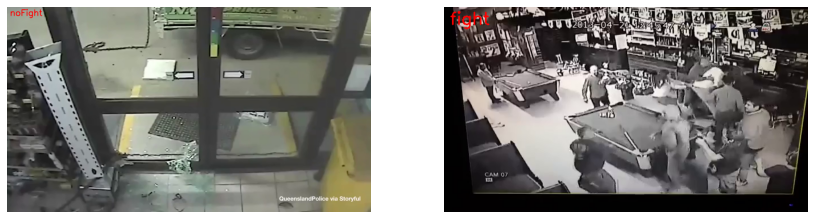

In [4]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('../input/fightoriginalcdata')

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 2)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'../input/fightoriginalcdata/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'../input/fightoriginalcdata/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [5]:
image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = "../input/fightoriginalcdata"
classes_list = ["fight", "noFight"]

model_output_size = len(classes_list)

# Extract Frames from each video to classify the actions inside them

In [6]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [7]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [8]:
features, labels = create_dataset()

Extracting Data of Class: fight
Extracting Data of Class: noFight


In [9]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

# Create the Neural Network 

In [11]:
# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

2022-05-10 14:27:09.056464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 14:27:09.140959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 14:27:09.141814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 14:27:09.143306: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

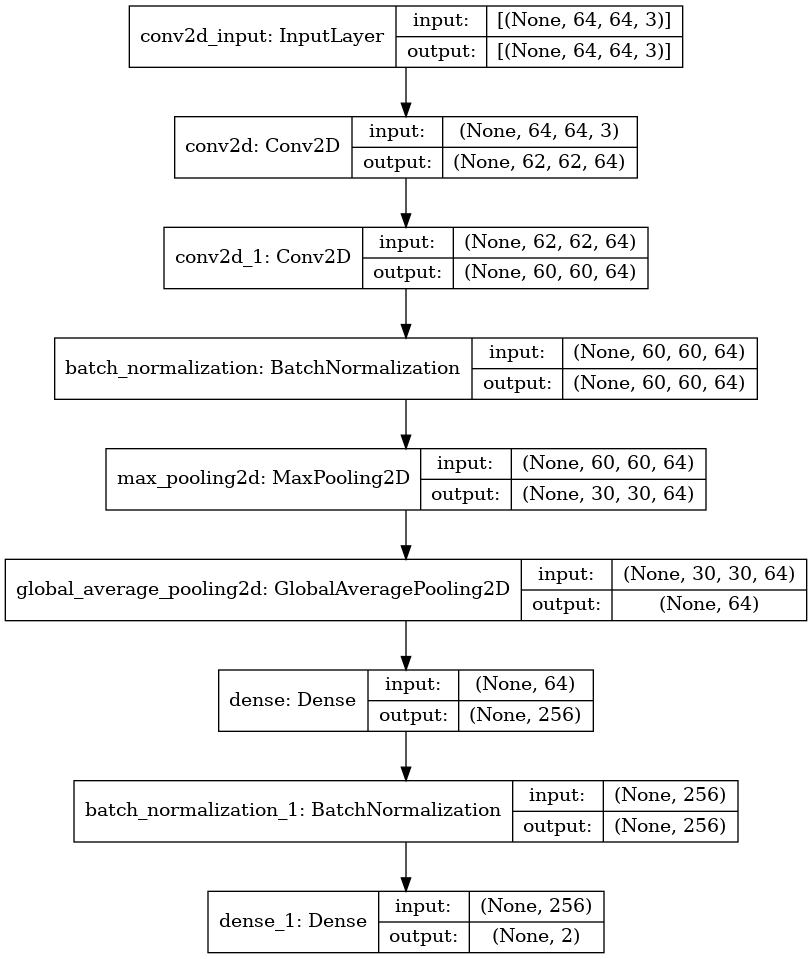

In [12]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [13]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

2022-05-10 14:27:12.352234: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 503316480 exceeds 10% of free system memory.
2022-05-10 14:27:12.890508: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 503316480 exceeds 10% of free system memory.
2022-05-10 14:27:13.286750: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-10 14:27:14.664182: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2560/2560 [==============================] - 17s 4ms/step - loss: 0.7090 - accuracy: 0.5635 - val_loss: 1.0711 - val_accuracy: 0.5000
Epoch 2/50
2560/2560 [==============================] - 10s 4ms/step - loss: 0.6900 - accuracy: 0.5749 - val_loss: 0.6478 - val_accuracy: 0.6078
Epoch 3/50
2560/2560 [==============================] - 10s 4ms/step - loss: 0.6498 - accuracy: 0.6294 - val_loss: 0.8386 - val_accuracy: 0.5129
Epoch 4/50
2560/2560 [==============================] - 9s 4ms/step - loss: 0.6104 - accuracy: 0.6698 - val_loss: 0.6910 - val_accuracy: 0.6238
Epoch 5/50
2560/2560 [==============================] - 10s 4ms/step - loss: 0.5730 - accuracy: 0.6941 - val_loss: 0.5017 - val_accuracy: 0.7367
Epoch 6/50
2560/2560 [==============================] - 10s 4ms/step - loss: 0.5298 - accuracy: 0.7355 - val_loss: 0.8188 - val_accuracy: 0.6270
Epoch 7/50
2560/2560 [==============================] - 10s 4ms/step - loss: 0.5018 - accuracy: 0.7527 - val_loss: 0.8091 - val_accuracy: 0.66

In [21]:
# Model Evaluation
model_evaluation_history = model.evaluate(features_test, labels_test)

100/100 [==============================] - 0s 4ms/step - loss: 0.0283 - accuracy: 0.9947


# Save the model

In [16]:
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving your Model
model.save(model_name)

# Visualize the training process

In [17]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

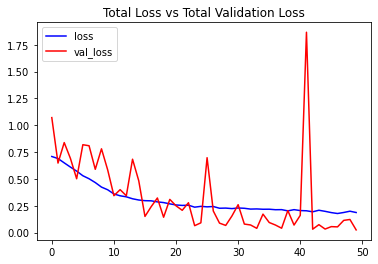

In [18]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

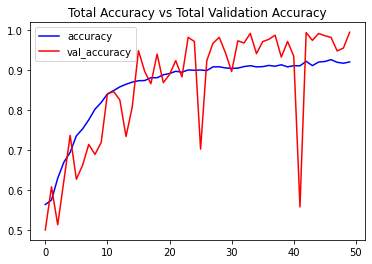

In [19]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')